README -- Out of memory errors <br>
This code is tuned for a RTX3060 12GB, if you have less memory, you will likely get "out of memory" errors with this code, try to aggressively reduce batch size (you can increase epochs to compensate)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
device = torch.device("cuda:0")


In [2]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [3]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, 1:]
val_inputs = sequences[:2000, 0:-1]
val_labels = sequences[:2000, -1]

# Attention Block - Scaled dot product attention

A very effective system that can find correlations between tokens is the attention block <br><br>

It takes in a series of tokens: input (sequence_length, embedding_size)<br>
we call this layer "attention head", you can have one head of self attention or many heads with different weights. <br> 
and computes the dot products with 3 sets of weights, called "keys", "queries" and "values" of size (emb_size, head_size) <br>
 
After this operation you have three tensors of size (sequence_length, head_size) <br>
you compute the similarity matrix (sequence_length, sequence_length) by multiplying keys with transposed queries. <br><br>

The next step is to tril (transform to lower triangular) and softmax the similarity matrix, and a scaling by sqrt(head_size) <br>
(This is why its called scaled dot product attention) <br>
Following is a dot product with the values. The output will be (sequence_length, head_size) <br>

This block has roughly a complexity of O(sequence_length^2) witch is sub optimal for long sequence lengths, so we use sligthly different attention blocks for that<br>

In [4]:
def visualize(activations):
    import matplotlib.pyplot as plt
    activations = activations
    print(activations.mean(), activations.std(), activations.min(), activations.max(), activations.shape)
    plt.imshow(activations[0].detach().cpu().numpy())
    plt.show()

In [5]:
class Attention(nn.Module):  
    def __init__(self, emb_size, head_size):
        super(Attention, self).__init__()
        self.head_size = head_size

        self.keys = nn.Linear(emb_size, head_size)
        self.queries = nn.Linear(emb_size, head_size)
        self.values = nn.Linear(emb_size, head_size) 
        self.rvalues = nn.Linear(head_size, emb_size)

    def forward(self, x, mask=True):
        k = self.keys(x)
        q = self.queries(x)
        v = self.values(x)

        similarity = k @ q.transpose(-2, -1)/(self.head_size**0.5)
        if mask: similarity[torch.tril(torch.ones_like(similarity)) == 0] = float("-inf")
        similarity = torch.softmax(similarity, dim = -1)
        
        attention = similarity @ v 
        attention = self.rvalues(attention)
        return attention


class FullyConnected(nn.Module):  
    def __init__(self, in_size, out_size, hidden_size, n_layers):
        super(FullyConnected, self).__init__()

        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for fc in self.fcx:
            x = x + F.gelu(fc(x)) # Residual connection not present in the original paper, but it helps with convergence
        x = self.fc2(x)
        return x


class Block(nn.Module): 
    def __init__(self, vocab_size, emb_size, head_size, hidden_size, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)
        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = Attention(emb_size, head_size)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

        self.fcout = nn.Linear(emb_size, vocab_size)

    def forward(self, x):          
        x = self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device)) * .1
        x = x + self.att(self.prenorm1(x)) 
        x = x + self.fc(self.prenorm2(x))
        x = self.fcout(x)
    
        return x
    
device = torch.device("cuda:0")
model = Block(vocab_size=vocab_size, emb_size=16, head_size=64, hidden_size=64, n_layers=2).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 6000
batch_size = 2048
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred.view(-1, 65), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")
    
    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))[:, -1]

        loss = F.cross_entropy(pred, val_labels[indexes].to(device))
        vlossi.append(loss.item())
    # with torch.no_grad():
    #     indexes = torch.randint(0, len(inputs), (batch_size//8,))
    #     pred = model(inputs[indexes].to(device))[:, -1]

    #     loss = F.cross_entropy(pred, labels[:,-1][indexes].to(device))
    #     vlossi.append(loss.item())

Millions of parameters: 0.02
Epoch ___0 - Loss: 4.347
Epoch _600 - Loss: 2.549
Epoch 1200 - Loss: 2.446
Epoch 1800 - Loss: 2.397
Epoch 2400 - Loss: 2.332
Epoch 3000 - Loss: 2.254
Epoch 3600 - Loss: 2.197
Epoch 4200 - Loss: 2.162
Epoch 4800 - Loss: 2.129
Epoch 5400 - Loss: 2.111


This performance is slightly worse than 20 layers MLP, but we are using just a single block (attention + 2 hidden layer MLP)  <br>
Note: we are using roughly 10k parameters instead of 370k

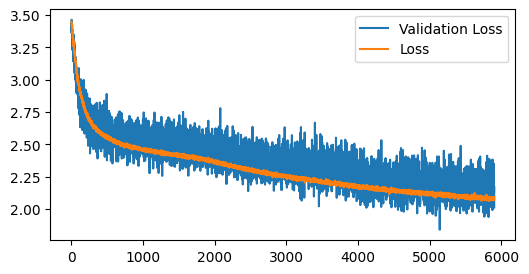

In [6]:
plt.figure(figsize=(6, 3))  
plt.plot(vlossi[100:], label='Validation Loss')
plt.plot(lossi[100:], label='Loss')
plt.legend()

In [7]:
string = "           \nKING RICHARD I"
print(string, end="")

with torch.no_grad():
    for _ in range(300):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred[0, -1, :], dim=0), 1).item()]
        print(string[-1], end="")


           
KING RICHARD I:
I with we it vour with is yor bndesaty.

RCep jou ho!
'Mooutth ward neatthe with thris
Shiron ghe mopu the wice:
Dou of moleas, flome astiny, wour's ris lon; pthastrour do they.


JUn ivon trieve
Yord warke is
somess yome mind of gsepune, a latit them not-on,
At las, astir my liss arices for my re

# Transformers 

Transformers consist of attention blocks in sequence, with residual connections 

In [26]:
class Block(nn.Module): 
    def __init__(self, emb_size, head_size, hidden_size, n_layers):
        super().__init__()

        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = Attention(emb_size, head_size)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

    def forward(self, x):          
        x = x + self.att(self.prenorm1(x)) 
        x = x + self.fc(self.prenorm2(x))
    
        return x

class Transformer(nn.Module): 
    def __init__(self, vocab_size, emb_size, n_blocks, head_size, hidden_size, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)
        
        self.norm = nn.LayerNorm(emb_size)
        self.blocks = nn.ModuleList([Block(emb_size, head_size, hidden_size, n_layers) for _ in range(n_blocks)])
        self.LinOut = nn.Linear(emb_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device)) * .1

        for block in self.blocks:
            x = x + block(self.norm(x))
            
        x = self.LinOut(self.norm(x))
        return x
    

device = torch.device("cuda:0")
model = Transformer(vocab_size=vocab_size, emb_size=64, n_blocks=8, head_size=64, hidden_size=64, n_layers=2).to(device)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 6000
batch_size = 2048
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred.view(-1, 65), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {loss.item():.3f}")

    with torch.no_grad():
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        loss = F.cross_entropy(pred[:, -1].view(-1, 65), val_labels[indexes].to(device).view(-1))
        vlossi.append(loss.item())

Millions of parameters: 0.28
Epoch ___0 - Loss: 4.316
Epoch _600 - Loss: 2.218
Epoch 1200 - Loss: 1.998
Epoch 1800 - Loss: 1.855
Epoch 2400 - Loss: 1.790
Epoch 3000 - Loss: 1.735
Epoch 3600 - Loss: 1.702
Epoch 4200 - Loss: 1.646
Epoch 4800 - Loss: 1.641
Epoch 5400 - Loss: 1.614


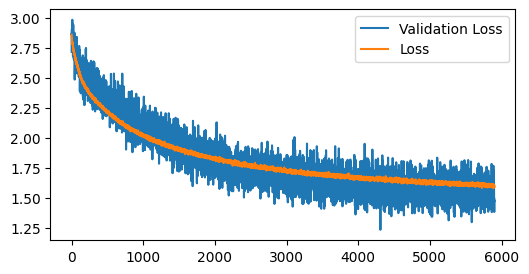

In [27]:
plt.figure(figsize=(6, 3))  
plt.plot(vlossi[100:], label='Validation Loss')
plt.plot(lossi[100:], label='Loss')
plt.legend()

# Results
As you can see we can get really good loss with the transformer, this architecture scales well up to GPT3.5 level performance with enough high quality data

In [28]:
print("Millions of parameters: ", round(sum(p.numel() for p in model.parameters() if p.requires_grad)/1000000, 2))
print([p.numel() for p in model.parameters() if p.requires_grad])

Millions of parameters:  0.28
[4160, 1280, 64, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 64, 64, 4096, 64, 4096, 64, 4096, 64, 4096, 64, 4160, 65]


In [29]:
model

Transformer(
  (embedding): Embedding(65, 64)
  (posemb): Embedding(20, 64)
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (blocks): ModuleList(
    (0-7): 8 x Block(
      (prenorm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (att): Attention(
        (keys): Linear(in_features=64, out_features=64, bias=True)
        (queries): Linear(in_features=64, out_features=64, bias=True)
        (values): Linear(in_features=64, out_features=64, bias=True)
        (rvalues): Linear(in_features=64, out_features=64, bias=True)
      )
      (prenorm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (fc): FullyConnected(
        (fc1): Linear(in_features=64, out_features=64, bias=True)
        (fcx): ModuleList(
          (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
        )
        (fc2): Linear(in_features=64, out_features=64, bias=True)
      )
    )
  )
  (LinOut): Linear(in_features=64, out_features=65, bias=True)
)

In [30]:
string = "           \nKING RICHARD I"
print(string, end="")

with torch.no_grad():
    for _ in range(300):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred[0, -1, :], dim=0), 1).item()]
        print(string[-1], end="")


           
KING RICHARD II:
Bask him.

KING RICHARD III:
Why, may fault: you match be soome daughter and out o' thee shall liesterfore.

BIONTES:
Sir, son's look husband
They breathe, and ever.

PETRUCHIO:
How dist he heart not with 'ciss
With art wipon the deperful as well.

Pray God very long before; 'Well.

NRICHARD:
Era